<a href="https://colab.research.google.com/github/BogdanGFTP/digit_predictions/blob/master/MNIST(0.99471).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, files
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, Callback
from keras import backend as K

TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_FILE = "model.h5"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

Using TensorFlow backend.


In [0]:
VERBOSITY = 1
EPOCHS = 100
BATCH_SIZE = 512
CLASSES = 10
CHANNELS = 1
IMAGE_SIZE = 28
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
VALIDATION_RATIO = 0.1

In [0]:
# Learning rate finder

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
path = "drive/My Drive/MNIST/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

y = train["label"]
x = train.drop(labels = ["label"], axis = 1) 

# Reshape data
x = x.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
test = test.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

# One-Hot encoding
y = to_categorical(y, num_classes=CLASSES)

In [5]:
import gc; gc.enable()
gc.collect()

7

In [0]:
# Prepare training/validation sets
x_training, x_validation, y_training, y_validation = train_test_split(x,
                                                                      y,
                                                                      test_size=VALIDATION_RATIO,
                                                                      shuffle = True)


In [0]:
K.clear_session()

In [17]:
inp = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu')(inp)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(8192, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8192, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(CLASSES, activation="softmax")(x)

model = Model(inp, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [0]:
# Data augmentation
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=1,
                                    zoom_range=0.1, 
                                    width_shift_range=0.05,
                                    height_shift_range=0.05)
data_generator.fit(x_training)

In [14]:
gc.collect()

9998

In [11]:
lrf = LR_Finder(start_lr=1e-6, end_lr=1e-1, step_size=50)
model.compile(loss='categorical_crossentropy', optimizer='ADAM', metrics=['accuracy'])
model.fit_generator(generator=data_generator.flow(x_training, y_training, batch_size=BATCH_SIZE),
                    epochs=1,
                    steps_per_epoch=x_training.shape[0] // BATCH_SIZE,
                    callbacks=[lrf])

Epoch 1/1
73/73 [==============================] - 20s 273ms/step - loss: 4.8804 - acc: 0.1842


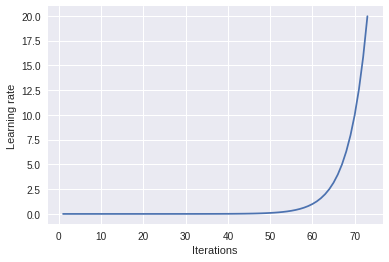

In [12]:
lrf.plot_lr()

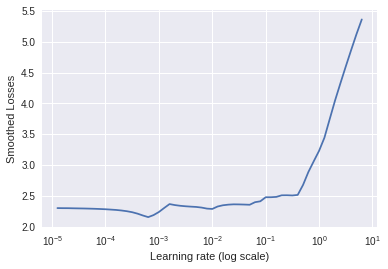

In [13]:
lrf.plot_smoothed_loss()

In [19]:
# Training
model.compile(optimizer=Adam(lr=1e-4, epsilon=1e-08, decay=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit_generator(data_generator.flow(x_training,
                                                  y_training,
                                                  batch_size=BATCH_SIZE),
                              epochs=EPOCHS,
                              validation_data=(x_validation, y_validation),
                              verbose=VERBOSITY,
                              steps_per_epoch=x_training.shape[0] // BATCH_SIZE,
                              callbacks=[CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=";")])
model.save_weights(MODEL_FILE)

Epoch 1/100
73/73 [==============================] - 21s 290ms/step - loss: 1.2180 - acc: 0.6080 - val_loss: 1.5011 - val_acc: 0.9043
Epoch 2/100
73/73 [==============================] - 18s 252ms/step - loss: 0.5257 - acc: 0.8323 - val_loss: 0.8684 - val_acc: 0.9450
Epoch 3/100
73/73 [==============================] - 18s 250ms/step - loss: 0.3140 - acc: 0.9014 - val_loss: 0.5555 - val_acc: 0.9648
Epoch 4/100
73/73 [==============================] - 18s 250ms/step - loss: 0.2257 - acc: 0.9300 - val_loss: 0.3624 - val_acc: 0.9769
Epoch 5/100
73/73 [==============================] - 18s 250ms/step - loss: 0.1846 - acc: 0.9415 - val_loss: 0.3493 - val_acc: 0.9776
Epoch 6/100
73/73 [==============================] - 18s 250ms/step - loss: 0.1530 - acc: 0.9513 - val_loss: 0.2665 - val_acc: 0.9831
Epoch 7/100
73/73 [==============================] - 18s 250ms/step - loss: 0.1400 - acc: 0.9548 - val_loss: 0.2631 - val_acc: 0.9836
Epoch 8/100
73/73 [==============================] - 18s 251ms

In [20]:
# Testing
predictions = model.predict(test, verbose=1)
results = np.argmax(predictions,axis = 1)
pd.DataFrame({"ImageId":list(range(1,len(results)+1)),
              "Label":results}).to_csv(KAGGLE_SUBMISSION_FILE,
                                           index=False,
                                           header=True)

28000/28000 [==============================] - 9s 310us/step
